In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Поиск и выбор набора данных для построения моделей машинного обучения. На основе выбранного набора данных студент должен построить модели машинного обучения для решения или задачи классификации, или задачи регрессии.

In [3]:
origin_data = pd.read_csv('forbes-top-2000-companies/Forbes Top2000 2017.csv')
origin_data.shape

(2000, 10)

# 2. Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

In [4]:
origin_data.head(10)

,Unnamed: 0,Rank,Company,Country,Sales,Profits,Assets,Market Value,Sector,Industry
0,NaN,1,ICBC,China,151.4,42.0,3473.2,229.8,Financials,Major Banks
1,NaN,2,China Construction Bank,China,134.2,35.0,3016.6,200.5,Financials,Regional Banks
2,NaN,3,Berkshire Hathaway,United States,222.9,24.1,620.9,409.9,Financials,Investment Services
3,NaN,4,JPMorgan Chase,United States,102.5,24.2,2513.0,306.6,Financials,Major Banks
4,NaN,5,Wells Fargo,United States,97.6,21.9,1943.4,274.4,Financials,Major Banks
5,NaN,6,Agricultural Bank of China,China,115.7,27.8,2816.0,149.2,Financials,Regional Banks
6,NaN,7,Bank of America,United States,92.2,16.6,2196.8,231.9,Financials,Major Banks
7,NaN,8,Bank of China,China,113.1,24.9,2611.5,141.3,Financials,Major Banks
8,NaN,9,Apple,United States,217.5,45.2,331.1,752.0,Information Technology,Computer Hardware
9,NaN,10,Toyota Motor,Japan,249.9,17.1,412.5,171.9,Consumer Discretionary,Auto & Truck Manufacturers


In [5]:
origin_data.dtypes

Unnamed: 0      float64
 Rank             int64
Company          object
Country          object
Sales           float64
Profits         float64
Assets          float64
Market Value    float64
Sector           object
Industry         object
dtype: object

In [6]:
origin_data.isnull().sum()

Unnamed: 0      2000
 Rank              0
Company            0
Country            0
Sales              0
Profits            0
Assets             0
Market Value       0
Sector           197
Industry         491
dtype: int64

In [7]:
origin_data.drop(["Unnamed: 0", " Rank", "Company"], axis=1, inplace=True)

In [8]:
origin_data.head(10)

,Country,Sales,Profits,Assets,Market Value,Sector,Industry
0,China,151.4,42.0,3473.2,229.8,Financials,Major Banks
1,China,134.2,35.0,3016.6,200.5,Financials,Regional Banks
2,United States,222.9,24.1,620.9,409.9,Financials,Investment Services
3,United States,102.5,24.2,2513.0,306.6,Financials,Major Banks
4,United States,97.6,21.9,1943.4,274.4,Financials,Major Banks
5,China,115.7,27.8,2816.0,149.2,Financials,Regional Banks
6,United States,92.2,16.6,2196.8,231.9,Financials,Major Banks
7,China,113.1,24.9,2611.5,141.3,Financials,Major Banks
8,United States,217.5,45.2,331.1,752.0,Information Technology,Computer Hardware
9,Japan,249.9,17.1,412.5,171.9,Consumer Discretionary,Auto & Truck Manufacturers


In [9]:
origin_data.isnull().sum()

Country           0
Sales             0
Profits           0
Assets            0
Market Value      0
Sector          197
Industry        491
dtype: int64

#### Удалим все строчки с пропусками

In [10]:
# data = origin_data.dropna(axis=0, how='any')
data = origin_data
data['Sector'] = ['Other' if pd.isna(i) else i for i in data['Sector']]
data['Industry'] = ['Other' if pd.isnull(i) else i for i in data['Industry']]
data.is_copy = False

### Топ 10 стран по количеству компаний в списке Forbs

In [11]:
type(data['Country'].value_counts()[:10])

pandas.core.series.Series

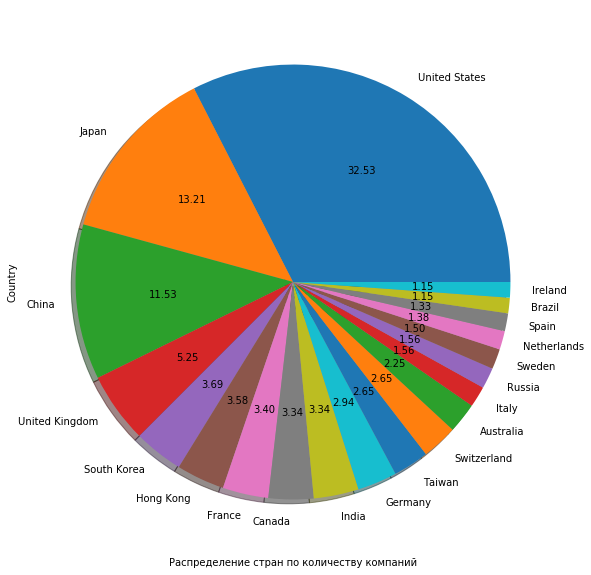

In [12]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
data['Country'].value_counts()[:20].plot(kind='pie', autopct='%.2f', shadow=True);
plt.xlabel("Распределение стран по количеству компаний");

### Стандартное распределение доходов компаний

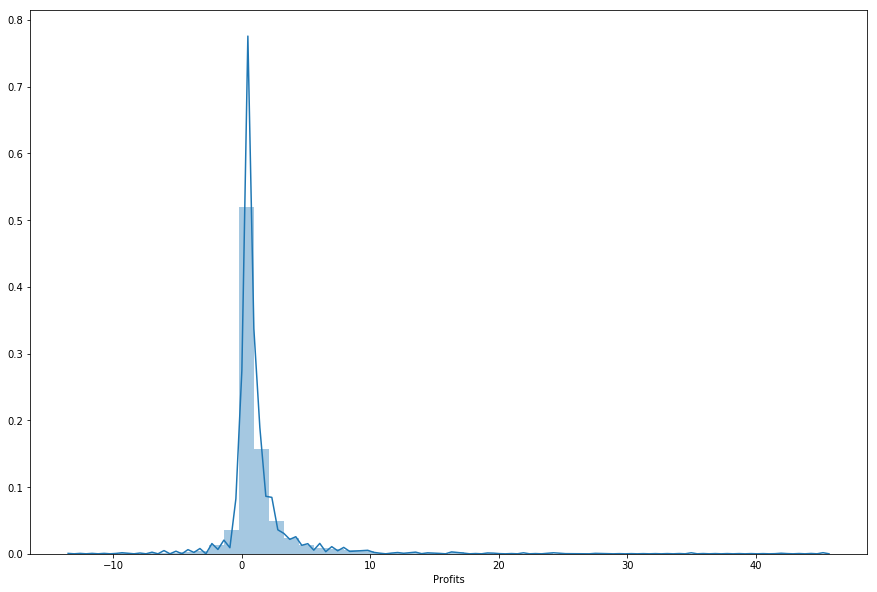

In [13]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.distplot(data['Profits'])

### Первые десять стран по общему заработку

In [14]:
countries = data[['Country', 'Profits']].groupby('Country').sum().sort_values('Profits', ascending=False)[:10]

In [15]:
countries

,Profits
Country,
United States,923.9522
China,367.7190
Japan,197.3650
France,84.3920
Hong Kong,80.6880
Germany,66.1590
United Kingdom,65.7330
South Korea,65.5960
Russia,61.1750


# 3. Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.

In [16]:
def encode_columns(origin_data):
    data = origin_data
    data.is_copy = False
    encoder = LabelEncoder()
    cols = ["Country", "Sector", "Industry"]

    for col in cols:
        data[col] = encoder.fit_transform(data[col])

    return data

In [17]:
data = encode_columns(data)

# 4. Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения. В зависимости от набора данных, порядок выполнения пунктов 2, 3, 4 может быть изменен.

In [18]:
corr = data.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,Country,Sales,Profits,Assets,Market Value,Sector,Industry
Country,1,0.0232937,0.0313004,-0.0485051,0.11713,-0.064289,-0.00616826
Sales,0.0232937,1,0.544257,0.373856,0.578612,-0.105826,-0.131679
Profits,0.0313004,0.544257,1,0.56103,0.741232,-0.0598649,-0.0217602
Assets,-0.0485051,0.373856,0.56103,1,0.32899,-0.0930483,0.0487835
Market Value,0.11713,0.578612,0.741232,0.32899,1,-0.0520159,-0.0341276
Sector,-0.064289,-0.105826,-0.0598649,-0.0930483,-0.0520159,1,0.137334
Industry,-0.00616826,-0.131679,-0.0217602,0.0487835,-0.0341276,0.137334,1


In [19]:
# data.drop(['Sector', 'Industry', 'Country'], axis=1, inplace=True)

In [20]:
data.shape

(2000, 7)

In [21]:
y = data['Profits']
data_X = data.drop(['Profits'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(data_X, y, random_state = 100, test_size=0.1)

### Посмотрим важности признаков с использованием RandomForestRegressor

6


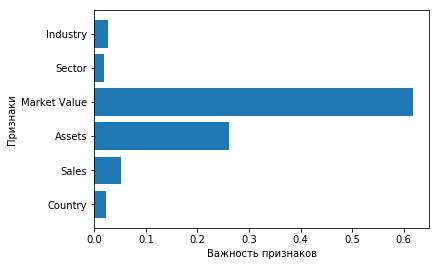

In [22]:
def plot_feature_importances():
    rfr_to_plot = RandomForestRegressor(random_state=100)
    rfr_to_plot.fit(X_train, y_train)
    n_features = data.shape[1] - 1
    print(n_features)
    plt.barh(range(n_features), rfr_to_plot.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), [i for i in data.columns if i != 'Profits'])
    plt.xlabel("Важность признаков")
    plt.ylabel("Признаки")
    
plot_feature_importances()

# 5. Выбор метрик для последующей оценки качества моделей. Необходимо выбрать не менее двух метрик и обосновать выбор.

Для исследования корректности моделей выберем метрики r2_score, mean_squared_error, mean_absolute_error

# 6. Выбор наиболее подходящих моделей для решения задачи классификации или регрессии. Необходимо использовать не менее трех моделей, хотя бы одна из которых должна быть ансамблевой.

Будем исследовать XGBoost, SVR, RandomForestRegressor

# 7. Формирование обучающей и тестовой выборок на основе исходного набора данных.

In [ ]:
def predict_test(model, X_train, X_test, y_train, y_test):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    print('root mean_squared_error train / test: {:0.3f} / {:0.3f}'.format(
        np.sqrt(mean_squared_error(y_train, pred_train)), np.sqrt(mean_squared_error(y_test, pred_test))))
    print('r2_score train / test: {:0.3f} / {:0.3f}'.format(
        r2_score(y_train, pred_train), r2_score(y_test, pred_test)))
    
    
def cvs_test_print(model, X_train, X_test, y_train, y_test, cv=10):
    scores = cross_val_score(model, X_train, y_train, cv=cv)
    print("Значения правильности перекрестной проверки: {}".format(scores))
    print("Среднее: {}.\nМаксимальное: {}.\nМинимальное: {}".format(np.mean(scores), np.max(scores), np.min(scores)))
    

def compare_predictions(model, test_data, y_test):
    fig, ax = plt.subplots(figsize=(15,10)) 
    plt.plot(np.linspace(0, len(y_test), len(test_data)), model.predict(test_data))
    plt.plot(np.linspace(0, len(y_test), len(y_test)), y_test)

In [ ]:
scaler = MinMaxScaler().fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

# 8. Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

#### XGBRegressor

In [ ]:
xgb = XGBRegressor(objective='reg:linear')
cvs_test_print(xgb, X_train_scaled, X_test_scaled, y_train, y_test)

xgb.fit(X_train_scaled, y_train)
predict_test(xgb, X_train_scaled, X_test_scaled, y_train, y_test)

[01:01:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

#### SVR

In [ ]:
svr = SVR().fit(X_train_scaled, y_train)
cvs_test_print(svr, X_train_scaled, X_test_scaled, y_train, y_test)
predict_test(svr, X_train_scaled, X_test_scaled, y_train, y_test)

Значения правильности перекрестной проверки: [0.40635753 0.33678538 0.26978726 0.46943239 0.32993553 0.23841765
 0.37125101 0.32014133 0.30767466 0.35199405]
Среднее: 0.34017767863356574.
Максимальное: 0.4694323907342888.
Минимальное: 0.23841764518380437
root mean_squared_error train / test: 2.333 / 1.862
r2_score train / test: 0.381 / 0.430


#### RFR

In [ ]:
rfr = RandomForestRegressor().fit(X_train_scaled, y_train)
cvs_test_print(rfr, X_train_scaled, X_test_scaled, y_train, y_test)
predict_test(rfr, X_train_scaled, X_test_scaled, y_train, y_test)

Значения правильности перекрестной проверки: [-0.09770043  0.696968    0.03702469  0.75127403  0.40807569 -0.06123274
  0.68638147  0.81152545  0.59454634  0.73099341]
Среднее: 0.45578558967926863.
Максимальное: 0.8115254450084137.
Минимальное: -0.09770043102241566
root mean_squared_error train / test: 0.732 / 1.579
r2_score train / test: 0.939 / 0.590


# 9. Подбор гиперпараметров для выбранных моделей.
# 10. Повторение пункта 8 для найденных оптимальных значений гиперпараметров. Сравнение качества полученных моделей с качеством baseline-моделей.

#### XGBRegressor

In [ ]:
xgb_grid_params = {
    'n_estimators': [10, 20, 50, 100, 200, 300, 500, 600, 700]
}

xgb_grid = GridSearchCV(XGBRegressor(), xgb_grid_params, cv = 10)
xgb_grid.fit(X_train, y_train)

[01:01:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:01:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[01:02:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20, 50, 100, 200, 300, 500, 600, 700]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
print("Лучший результат модели XGBoost с использованием GridSearchCV:",
      xgb_grid.best_score_)
print("Наилучшие значения параметров: {}".format(xgb_grid.best_params_))

Лучший результат модели XGBoost с использованием GridSearchCV: 0.5195560618389029
Наилучшие значения параметров: {'n_estimators': 500}


#### RFR

In [ ]:
rfr_grid_params = {
    'max_depth': [5, 10, 20, 40, 60, 90],
}

rfr_grid = GridSearchCV(RandomForestRegressor(), rfr_grid_params, cv=10)
rfr_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 20, 40, 60, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
print("Лучший результат модели RandomForestRegressor с использованием GridSearchCV:",
      rfr_grid.best_score_)
print("Наилучшие значения параметров: {}".format(rfr_grid.best_params_))
predict_test(rfr_grid, X_train_scaled, X_test_scaled, y_train, y_test)

Лучший результат модели RandomForestRegressor с использованием GridSearchCV: 0.4994494449556189
Наилучшие значения параметров: {'max_depth': 5}
root mean_squared_error train / test: 1.260 / 1.545
r2_score train / test: 0.819 / 0.607


#### SVR

In [ ]:
svr_grid_params = {'C': np.array([0.1, 1, 10, 100, 1000]), 'gamma': np.array([0.001, 0.01, 0.1, 1, 10])}
svr_grid = GridSearchCV(SVR(), svr_grid_params, cv=5)
svr_grid.fit(X_train_scaled, y_train)

In [ ]:
print("Наил знач правильности перекр проверки: {:.2f}".format(svr_grid.best_score_))
print("Наил знач правильности на тесте: {:.2f}".format(svr_grid.score(X_test_scaled, y_test)))
print("Наил параметры: ", svr_grid.best_params_)

# 11. Формирование выводов о качестве построенных моделей на основе выбранных метрик.

### Из вышеприведенных исследований можно сделать вывод, что лучшей среди всех используемых моделей оказалась SVR.

Наилучшее значечние правильности cros_val_score: 0.62
Наилучшее значение правильности на тесте: 0.76
Наилучгие параметры:  {'C': 1000.0, 'gamma': 1.0}

In [ ]:
compare_predictions(svr_grid, X_test_scaled, y_test)

In [ ]:
predict_test(svr_grid, X_train_scaled, X_test_scaled, y_train, y_test)

### Видно, средняя квадратическая ошибка чуть больше 1 миллиарда долларов